In [177]:
import matplotlib.pyplot as plt 
import matplotlib.image as img
import numpy as np
from skimage import color
from sklearn.decomposition import PCA
import os
import scipy
import math


# ============ preprocessing: index -> img_name, index -> landmarks ============ #
def read_files(path):
    file_list = os.listdir(path)
    file_list = [path + file for file in file_list]
    file_list.sort()
    return file_list


# Question 1

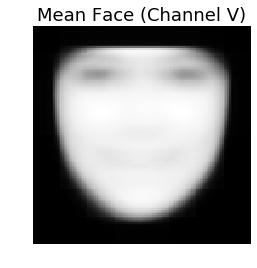

In [178]:
num_train = 800;
num_test = 200;
num_eigenfaces = 10;
img_list = read_files("images/")
train_face_matrix = np.zeros((128*128, 800))
train_face_matrix_central = np.zeros((128*128, 800))
test_face_matrix_origin = []
test_face_matrix_central = np.zeros((128*128, 200))

# ============ 2.1 Q1.1 compute mean face ============= #
mean_face = np.zeros((128, 128))
for i in range(num_train):
    image = color.rgb2hsv(img.imread(img_list[i]))[:, :, 2]
    mean_face += image
    train_face_matrix[:, i] = np.reshape(image, (128*128))

mean_face /= num_train
mean_face_vector = np.reshape(mean_face, (128*128))
plt.imshow(mean_face, cmap='Greys_r') # show grey image (only channel v)
plt.axis('off') 
plt.title('Mean Face (Channel V)', fontsize=18)
plt.show()

# centralize train_face_matrix
for i in range(num_train):
    train_face_matrix_central[:, i] = train_face_matrix[:, i] - mean_face_vector

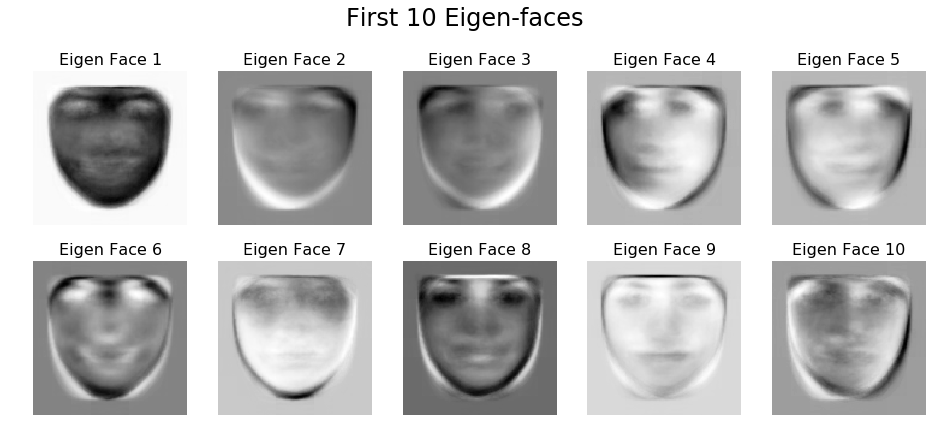

In [179]:
# ============ 2.1 Q1.2 compute eigen-faces ============= #
pca = PCA(n_components=50)
pca.fit(train_face_matrix_central.transpose())
eigen_vectors = pca.components_.transpose()

# display first 10 eigen-faces
plt.figure(figsize=(16, 7))
plt.suptitle('First 10 Eigen-faces', fontsize=24,x=0.5,y=0.97)
for i in range(num_eigenfaces):
    eigen_face_img = np.reshape(eigen_vectors[:, i], (128, 128))
    plt.subplot(2, 5, 1+i)
    plt.axis('off')
    plt.title('Eigen Face ' + str(i+1), fontsize=16)
    plt.imshow(eigen_face_img, cmap='Greys_r')
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

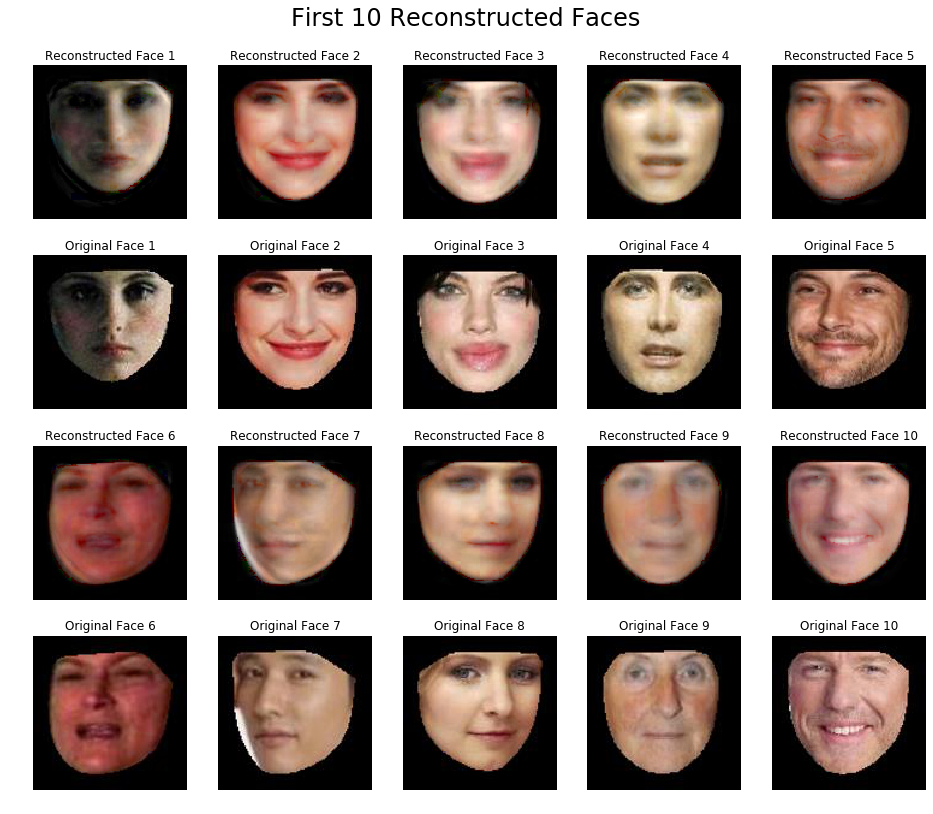

In [180]:
# ============ 2.1 Q1.3 reconstruct 10 faces ============= #
# read and centralize test images
mean_face_matrix = np.zeros((128*128, 200))
for i in range(num_test):
    mean_face_matrix[:, i] += mean_face_vector
    image = img.imread(img_list[800+i])
    test_face_matrix_origin.append(image)
    image_hsv = color.rgb2hsv(image)[:, :, 2]
    test_face_matrix_central[:, i] = np.reshape(image_hsv, (128*128)) - mean_face_vector

# project test faces to eigen-vectors
beta = np.dot(test_face_matrix_central.transpose(), eigen_vectors)
reconstruct_faces = np.dot(eigen_vectors, beta.transpose()) + mean_face_matrix

# plot first 10 reconstructed faces and their original faces
plt.figure(figsize=(16, 14))
plt.suptitle('First 10 Reconstructed Faces', fontsize=24, x=0.5, y=0.92)
for i in range(num_eigenfaces):
    # plot reconstructed image
    hsv_img = color.rgb2hsv(test_face_matrix_origin[i])
    hsv_img[:, :, 2] = np.reshape(reconstruct_faces[:, i], (128, 128))
    recons_image = color.hsv2rgb(hsv_img)
    pos = 1 + i
    if i >= 5:
        pos = 6 + i
    plt.subplot(4, 5, pos)
    plt.axis('off')
    plt.title('Reconstructed Face ' + str(i+1), fontsize=12)
    plt.imshow(color.hsv2rgb(hsv_img))
    # plot original image
    plt.subplot(4, 5, pos+5)
    plt.axis('off')
    plt.title('Original Face ' + str(i+1), fontsize=12)
    plt.imshow(test_face_matrix_origin[i])
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()


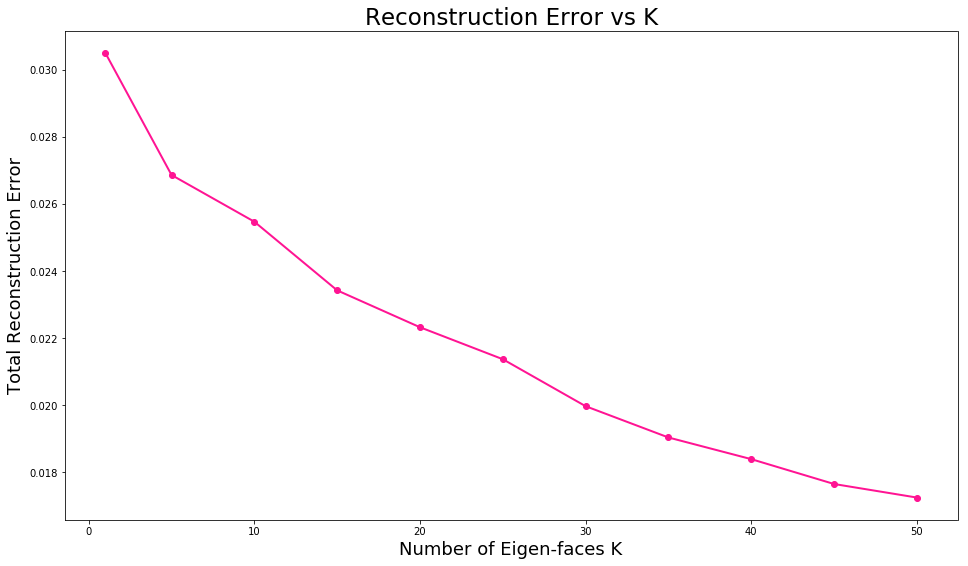

In [181]:
# ============ 2.1 Q1.4 plot reconstruction error ============= #
# extract original channel v
test_face_matrix_v = np.zeros((128*128, 200))
for i in range(num_test):
    hsv_img = color.rgb2hsv(test_face_matrix_origin[i])
    test_face_matrix_v[:, i] += np.reshape(hsv_img[:, :, 2], (128*128))

# calculate reconstruction error over k
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
errors = []
for k in k_values:
    # compute k eigen-faces
    pca = PCA(n_components=k)
    pca.fit(train_face_matrix_central.transpose())
    eigen_vectors = pca.components_.transpose()
    
    # reconstruct 200 test faces
    beta = np.dot(test_face_matrix_central.transpose(), eigen_vectors)
    reconstruct_faces = np.dot(eigen_vectors, beta.transpose()) + mean_face_matrix
    
    # normalize reconstructed faces to [0, 1]
    for i in range(num_test):
        cur_img = reconstruct_faces[:, i]
        min_v = cur_img.min()
        max_v = cur_img.max()
        cur_img -= min_v * np.ones((128*128))
        cur_img /= (max_v - min_v)
        reconstruct_faces[:, i] = cur_img
    
    # calculate total error
    error = np.power(reconstruct_faces - test_face_matrix_v, 2).sum() / (128*128*200)
    errors.append(error)

# plot reconstruction error
plt.figure(figsize=(16,9))
plt.xlabel('Number of Eigen-faces K', fontsize = 18)
plt.ylabel('Total Reconstruction Error', fontsize = 18)
plt.title('Reconstruction Error vs K', fontsize = 23)
plt.plot(k_values, errors, 'o-', color='deeppink', lw=2)
plt.show()


# Question 2

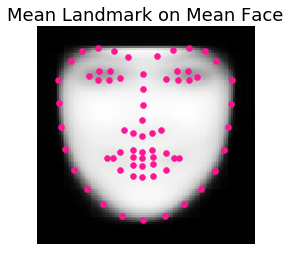

In [182]:
landmark_list = read_files("landmarks/")
train_landmark_matrix = np.zeros((68*2, 800))
train_landmark_matrix_central = np.zeros((68*2, 800))
test_landmark_matrix_origin = []
test_landmark_matrix_central = np.zeros((68*2, 200))

# ============ 2.1 Q2.1 compute mean landmark ============= #
mean_landmark = np.zeros((68, 2))
for i in range(num_train):
    landmark = scipy.io.loadmat(landmark_list[i])['lms']
    mean_landmark += landmark
    train_landmark_matrix[:, i] = np.reshape(landmark, (68*2))

mean_landmark /= num_train
mean_landmark_vector = np.reshape(mean_landmark, (68*2))
plt.imshow(mean_face, cmap='Greys_r') # show grey image (only channel v)
plt.scatter(mean_landmark[:, 0], mean_landmark[:, 1], color='deeppink', lw=0.5)
plt.axis('off') 
plt.title('Mean Landmark on Mean Face', fontsize=18)
plt.show()

# centralize train_landmark_matrix
for i in range(num_train):
    train_landmark_matrix_central[:, i] = train_landmark_matrix[:, i] - mean_landmark_vector


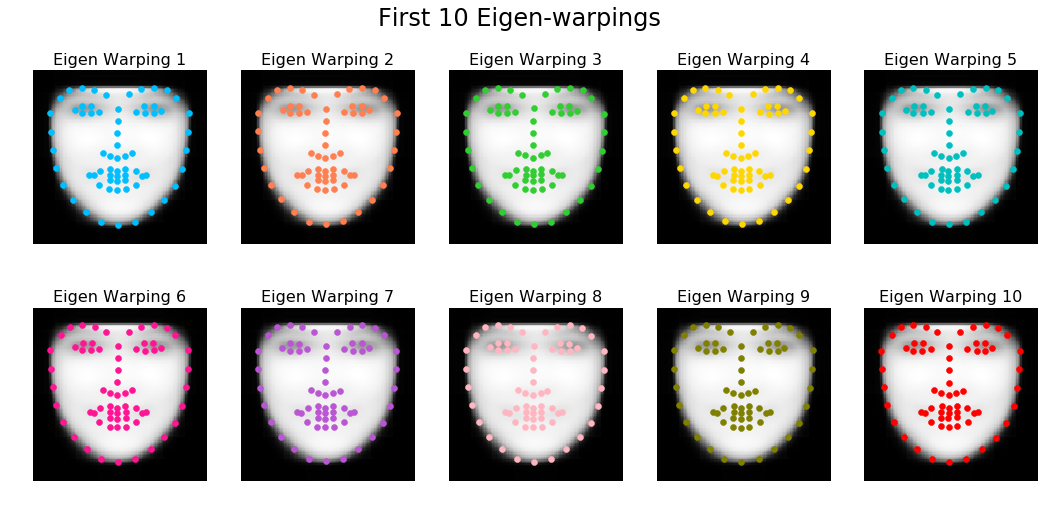

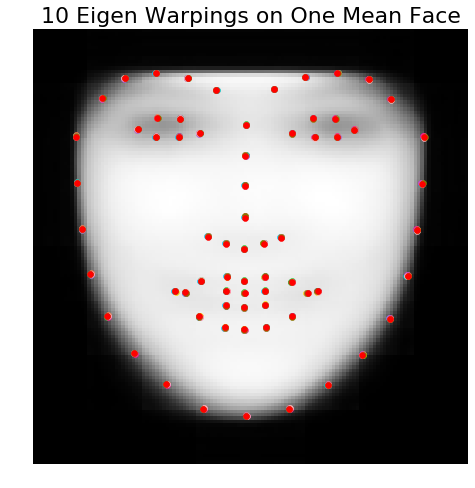

In [183]:
# ============ 2.1 Q2.2 compute eigen-warpings ============= #
pca = PCA(n_components=10)
pca.fit(train_landmark_matrix_central.transpose())
eigen_warpings = pca.components_.transpose()

# display first 10 eigen-warpings
line_color=['deepskyblue', 'coral', 'limegreen', 'gold', 'c', 'deeppink', 'mediumorchid', 'lightpink', 'olive', 'red']
plt.figure(1, figsize=(18, 8))
plt.suptitle('First 10 Eigen-warpings', fontsize=24, x=0.5, y=0.97)
plt.figure(2, figsize=(8, 8))
for i in range(num_eigenfaces):
    eigen_warping_img = np.reshape(eigen_warpings[:, i]+mean_landmark_vector, (68, 2))
    plt.figure(1)
    plt.subplot(2, 5, 1+i)
    plt.axis('off')
    plt.title('Eigen Warping ' + str(i+1), fontsize=16)
    plt.imshow(mean_face, cmap='Greys_r')
    plt.scatter(eigen_warping_img[:, 0], eigen_warping_img[:, 1], color=line_color[i], lw=0.5)
    
    plt.figure(2)
    plt.axis('off')
    plt.title('10 Eigen Warpings on One Mean Face', fontsize=22)
    plt.scatter(eigen_warping_img[:, 0], eigen_warping_img[:, 1], color=line_color[i], lw=0.5)
    plt.imshow(mean_face, cmap='Greys_r')
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()


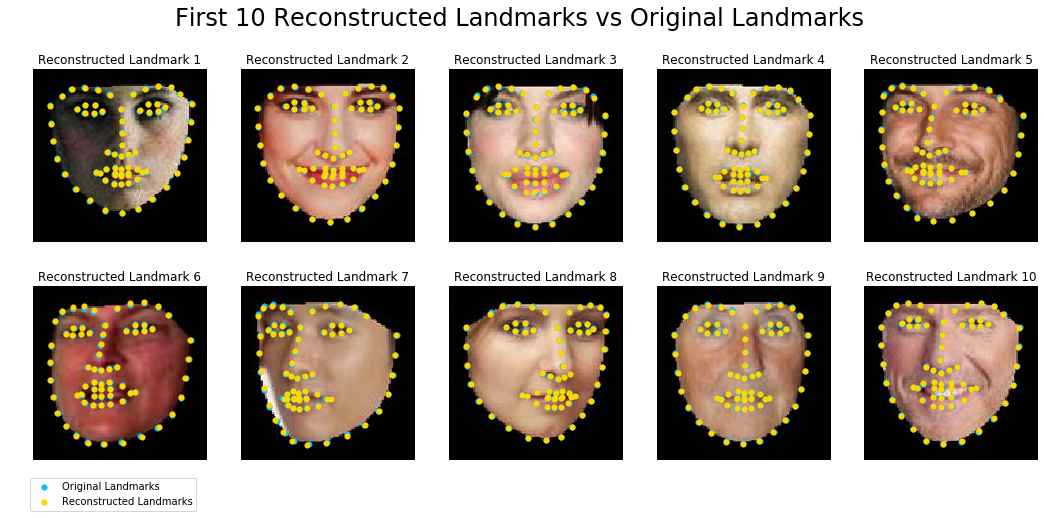

In [184]:
# ============ 2.1 Q2.3 reconstruct 10 landmarks ============= #
# read and centralize test landmarks
mean_landmark_matrix = np.zeros((68*2, 200))
for i in range(num_test):
    mean_landmark_matrix[:, i] += mean_landmark_vector
    landmark = scipy.io.loadmat(landmark_list[800+i])['lms']
    test_landmark_matrix_origin.append(landmark)
    test_landmark_matrix_central[:, i] = np.reshape(landmark, (68*2)) - mean_landmark_vector

# project test landmarks to eigen-warpings
beta = np.dot(test_landmark_matrix_central.transpose(), eigen_warpings)
reconstruct_landmarks = np.dot(eigen_warpings, beta.transpose()) + mean_landmark_matrix

# plot first 10 reconstructed landmarks and their original landmarks
plt.figure(figsize=(18, 8))
plt.suptitle('First 10 Reconstructed Landmarks vs Original Landmarks', fontsize=24, x=0.5, y=0.95)
for i in range(num_eigenfaces):
    # plot original landmark
    plt.subplot(2, 5, 1+i)
    plt.axis('off')
    plt.title('Reconstructed Landmark ' + str(i+1), fontsize=12)
    plt.imshow(test_face_matrix_origin[i])
    orig_landmark = test_landmark_matrix_origin[i]
    l1 = plt.scatter(orig_landmark[:, 0], orig_landmark[:, 1], color='deepskyblue', lw=0.1)
    # plot reconstructed landmark
    recons_landmark = reconstruct_landmarks[:, i].reshape((68, 2))
    l2 = plt.scatter(recons_landmark[:, 0], recons_landmark[:, 1], color='gold', lw=0.1)
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.legend(handles=[l1, l2], labels=['Original Landmarks', 'Reconstructed Landmarks'],  bbox_to_anchor=(-4.85,-0.2), loc='center left')
plt.show()


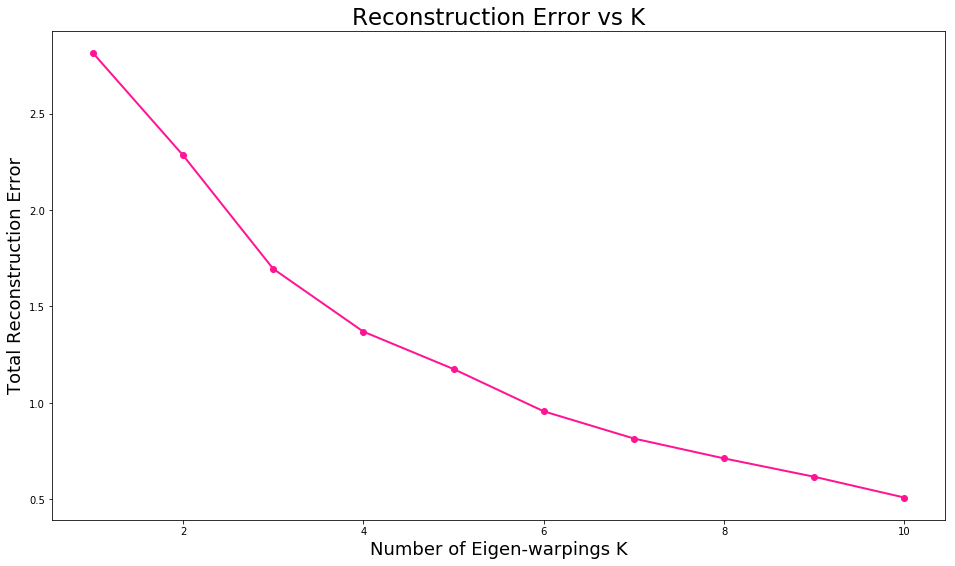

In [185]:
# ============ 2.1 Q2.4 plot reconstruction error ============= #
# calculate reconstruction error over k
errors = []
for k in range(10):
    # compute k eigen-warpings
    pca = PCA(n_components=k+1)
    pca.fit(train_landmark_matrix_central.transpose())
    eigen_warpings = pca.components_.transpose()
    
    # reconstruct 200 test landmarks
    beta = np.dot(test_landmark_matrix_central.transpose(), eigen_warpings)
    reconstruct_landmarks = np.dot(eigen_warpings, beta.transpose()) + mean_landmark_matrix
    
    # calculate total error
    error = 0
    for i in range(200):
        orig_landmark = test_landmark_matrix_origin[i]
        recons_landmark = reconstruct_landmarks[:, i].reshape((68, 2))
        for j in range(68):
            orig_point = orig_landmark[j]
            recons_point = recons_landmark[j]
            error += math.sqrt(np.power(orig_point[0] - recons_point[0], 2) + np.power(orig_point[1] - recons_point[1], 2))
    error /= 200 * 68
    errors.append(error)

# plot reconstruction error
plt.figure(figsize=(16,9))
plt.xlabel('Number of Eigen-warpings K', fontsize = 18)
plt.ylabel('Total Reconstruction Error', fontsize = 18)
plt.title('Reconstruction Error vs K', fontsize = 23)
plt.plot([i+1 for i in range(10)], errors, 'o-', color='deeppink', lw=2)
plt.show()


# Question 3

In [186]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 14 15:26:24 2018

@author: dell
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
import datetime
import imageio

##################################
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        p1=(int(p[0]),int(p[1]))
        if p1[1]<=rect[2]-1 and p1[0]<=rect[2]-1 and p1[1]>=rect[0] and p1[0]>=rect[0]:
            subdiv.insert(p1) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    w,h,num_chans = img1.shape
    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], num_chans), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    if num_chans==1:
        img2Rect=np.reshape(img2Rect,(r2[3], r2[2], num_chans))
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    if num_chans==1:
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( 1.0 - mask )
     
    else:
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 

###################################
def warp(Image,sc,tc):
    '''
    Image: the image to be warped
    sc: original landmarks
    tc: warped landmarks
    '''
    HW,_,_=Image.shape
    cornerps=[[0,0],[0,HW-1],[HW-1,0],[HW-1,HW-1]]
    #cornerps=[[0,0],[0,HW-1],[HW-1,0],[HW-1,HW-1],[0,np.floor(HW/2)],[np.floor(HW/2),0],[HW-1,np.floor(HW/2)],[np.floor(HW/2),HW-1]]

    scl=sc.astype(np.int64).tolist()+cornerps
    tcl=tc.astype(np.int64).tolist()+cornerps
    imgWarped = np.copy(Image);    
    rect = (0, 0, HW, HW)
    dt = calculateDelaunayTriangles(rect,tcl)
# Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(scl[dt[i][j]])
            t2.append(tcl[dt[i][j]])
        
        warpTriangle(Image, imgWarped, t1, t2)
    return imgWarped

#########################################
def plot(samples,Nh,Nc,channel,IMG_HEIGHT, IMG_WIDTH):
    fig = plt.figure(figsize=(Nc, Nh))
    plt.clf()
    gs = gridspec.GridSpec(Nh, Nc)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[0:Nh*Nc,:,:,:]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if channel==1:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH)
            immin=(image[:,:]).min()
            immax=(image[:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image,cmap ='gray')
        else:
            image=sample.reshape(IMG_HEIGHT, IMG_WIDTH,channel)
            immin=(image[:,:,:]).min()
            immax=(image[:,:,:]).max()
            image=(image-immin)/(immax-immin+1e-8)
            plt.imshow(image)
    return fig 





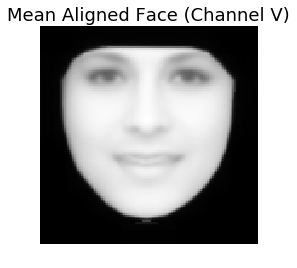

(16384, 800)


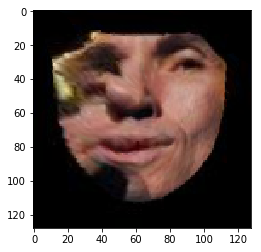

In [187]:
train_aligned_face_matrix = np.zeros((128*128, 800))
train_aligned_face_matrix_central = np.zeros((128*128, 800))
mean_aligned_face = np.zeros((128, 128))

# ============ 2.1 Q3.1 align training image to mean position ============= #
for i in range(num_train):
    image = img.imread(img_list[i])
    ori_landmark = scipy.io.loadmat(landmark_list[i])['lms']
    warped_face = warp(image, ori_landmark, mean_landmark)
    warped_face_v = color.rgb2hsv(warped_face)[:, :, 2]
    mean_aligned_face += warped_face_v
    train_aligned_face_matrix[:, i] = warped_face_v.reshape((128*128))

mean_aligned_face /= num_train
mean_aligned_face_vector = mean_aligned_face.reshape((128*128))

# centralize train_aligned_face_matrix
for i in range(num_train):
    train_aligned_face_matrix_central[:, i] = train_aligned_face_matrix[:, i] - mean_aligned_face_vector    

plt.imshow(mean_aligned_face, cmap='Greys_r') # show grey image (only channel v)
plt.axis('off') 
plt.title('Mean Aligned Face (Channel V)', fontsize=18)
plt.show()
plt.imshow(warped_face)


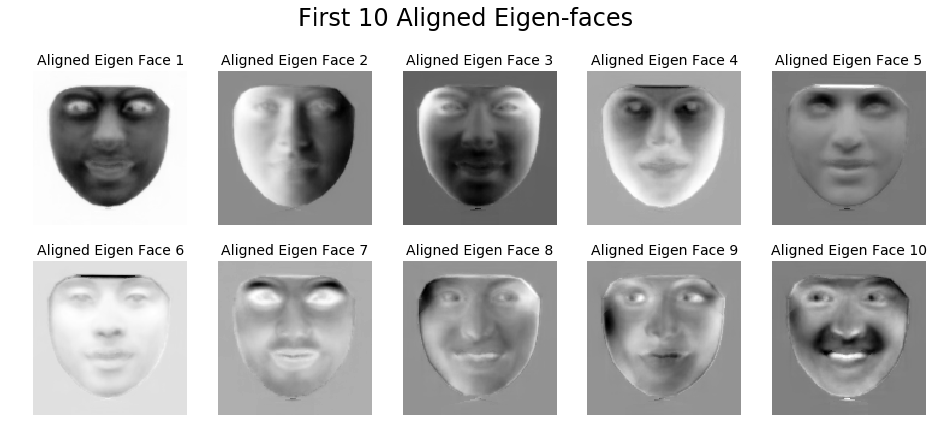

In [188]:
# ============ 2.1 Q3.2 compute eigen-faces of aligned faces ============= #
pca = PCA(n_components=50)
pca.fit(train_aligned_face_matrix_central.transpose())
aligned_eigen_vectors = pca.components_.transpose()

# display first 10 aligned eigen-faces
plt.figure(figsize=(16, 7))
plt.suptitle('First 10 Aligned Eigen-faces', fontsize=24,x=0.5,y=0.97)
for i in range(num_eigenfaces):
    eigen_face_img = np.reshape(aligned_eigen_vectors[:, i], (128, 128))
    plt.subplot(2, 5, 1+i)
    plt.axis('off')
    plt.title('Aligned Eigen Face ' + str(i+1), fontsize=14)
    plt.imshow(eigen_face_img, cmap='Greys_r')
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()


In [189]:
# ============ 2.1 Q3.3 reconstruct landmarks of test data ============= #
# use results from Q2 reconstruct_landmarks (136x200)

test_aligned_face_hsv = []
test_aligned_face_matrix_central = np.zeros((128*128, 200))
mean_aligned_face_matrix = np.zeros((128*128, 200))

# ============ 2.1 Q3.4 warp test image to mean position ============= #
for i in range(num_test):
    mean_aligned_face_matrix[:, i] += mean_aligned_face_vector
    image = img.imread(img_list[800+i])
    ori_landmark = scipy.io.loadmat(landmark_list[800+i])['lms']
    warped_face = warp(image, ori_landmark, mean_landmark)
    warped_face_hsv = color.rgb2hsv(warped_face)
    test_aligned_face_hsv.append(warped_face_hsv)
    cur_aligned_face = warped_face_hsv[:, :, 2].reshape((128*128))
    test_aligned_face_matrix_central[:, i] = cur_aligned_face - mean_aligned_face_vector    


200
(128, 128, 3)
(16384, 200)
[0.00018137 0.00014706 0.00014216 ... 0.         0.         0.        ]
[0.00018137 0.00014706 0.00014216 ... 0.         0.         0.        ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

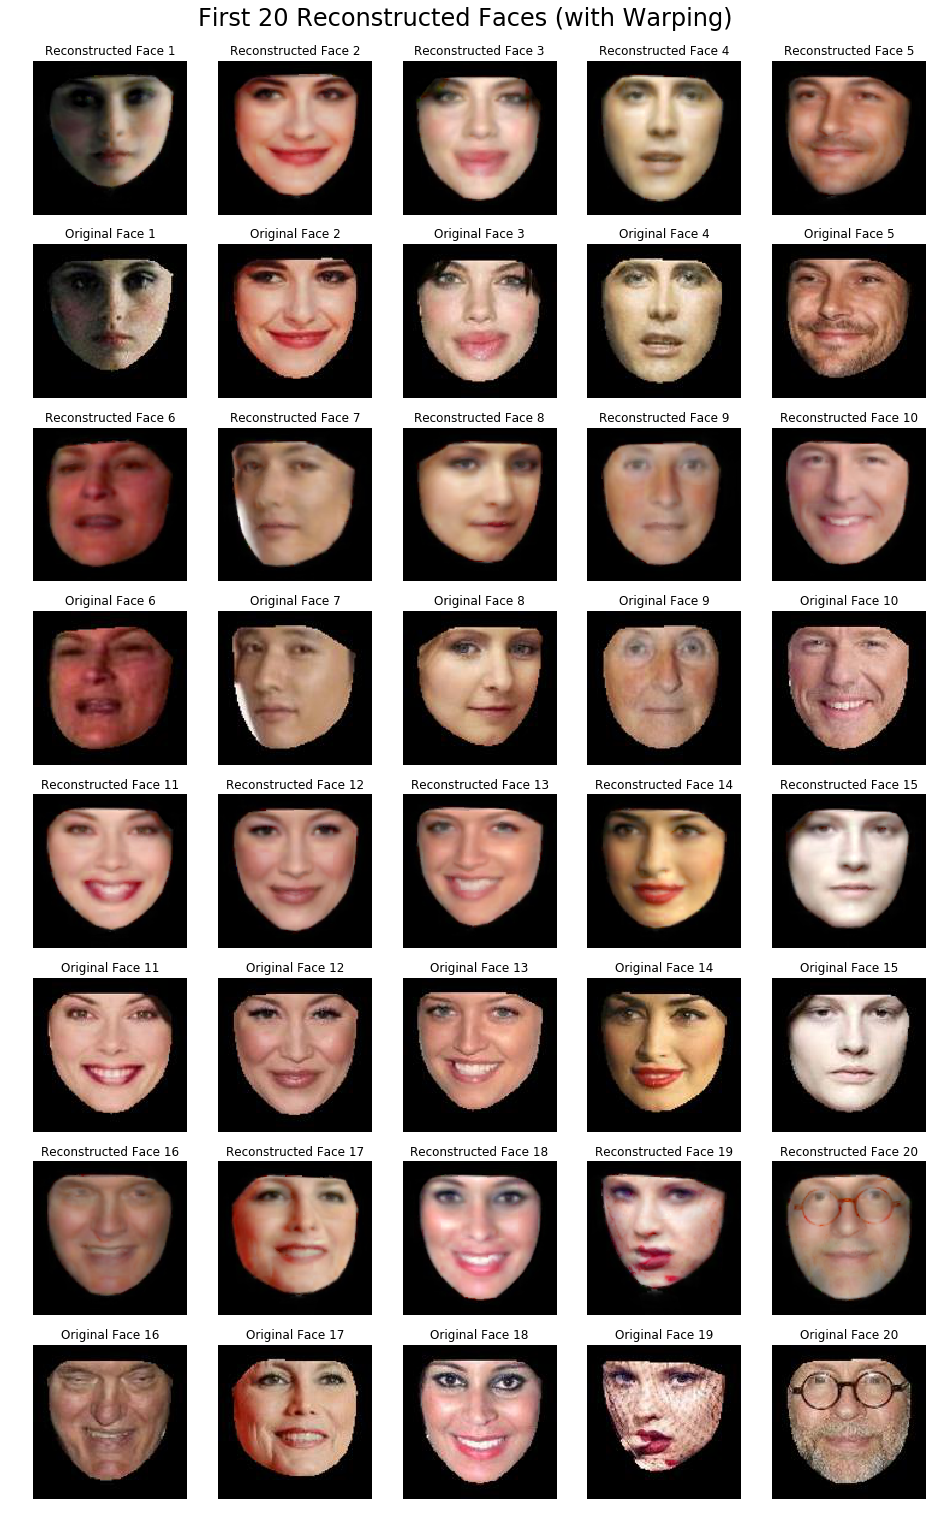

In [213]:
# ============ 2.1 Q3.5 reconstruct test faces at mean position ============= #
# project aligned test faces to aligned eigen-vectors
aligned_beta = np.dot(test_aligned_face_matrix_central.transpose(), aligned_eigen_vectors)
reconstruct_aligned_faces = np.dot(aligned_eigen_vectors, aligned_beta.transpose()) + mean_aligned_face_matrix

# ============ 2.1 Q3.6 warp reconstructed test faces to reconstructed landmarks ============= #
# plot first 20 reconstructed faces and their original faces
plt.figure(figsize=(16, 27))
plt.suptitle('First 20 Reconstructed Faces (with Warping)', fontsize=24, x=0.5, y=0.9)
for i in range(20):
    # plot reconstructed image
    hsv_img = test_aligned_face_hsv[i]
    hsv_img[:, :, 2] = np.reshape(reconstruct_aligned_faces[:, i], (128, 128))
    recons_rgb_image = color.hsv2rgb(hsv_img)
    recons_image = warp(recons_rgb_image, mean_landmark, reconstruct_landmarks[:, i].reshape((68, 2)))
    pos = 1 + i
    if i >= 15:
        pos = 16 + i
    elif i >= 10:
        pos = 11 + i
    elif i >= 5:
        pos = 6 + i
    plt.subplot(8, 5, pos)
    plt.axis('off')
    plt.title('Reconstructed Face ' + str(i+1), fontsize=12)
    plt.imshow(recons_image)
    # plot original image
    plt.subplot(8, 5, pos+5)
    plt.axis('off')
    plt.title('Original Face ' + str(i+1), fontsize=12)
    plt.imshow(test_face_matrix_origin[i])
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()


/Users/hannah_wang/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:268: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/hannah_wang/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:268: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/hannah_wang/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:268: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/hannah_wang/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:268: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/hannah_wang/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:268: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/hannah_wang/anaconda3/lib/python3.6/site-packages/skimage/color/colorconv.py:268: RuntimeWarning: divide by zero encountered in true_divid

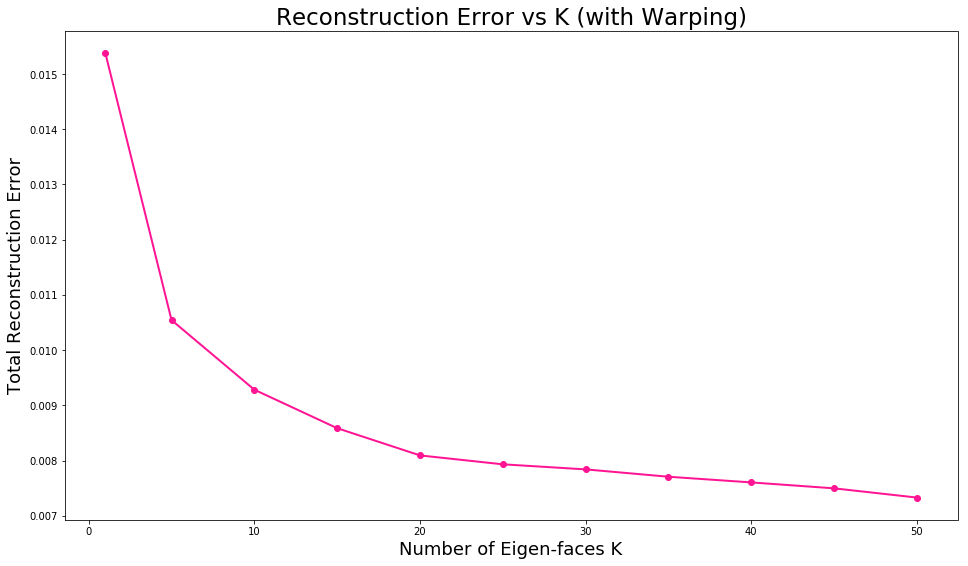

In [214]:
# ============ 2.1 Q3.7 plot reconstruction error ============= #
# calculate reconstruction error over k
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
errors_with_warping = []
for k in k_values:
    # compute k eigen-faces
    pca = PCA(n_components=k)
    pca.fit(train_aligned_face_matrix_central.transpose())
    aligned_eigen_vectors = pca.components_.transpose()
    
    # reconstruct 200 test faces
    aligned_beta = np.dot(test_aligned_face_matrix_central.transpose(), aligned_eigen_vectors)
    reconstruct_aligned_faces = np.dot(aligned_eigen_vectors, aligned_beta.transpose()) + mean_aligned_face_matrix

    # warp back
    final_recons_faces_v = np.zeros((128*128, 200))
    for i in range(num_test):
        hsv_img = test_aligned_face_hsv[i]
        hsv_img[:, :, 2] = np.reshape(reconstruct_aligned_faces[:, i], (128, 128))
        recons_rgb_image = color.hsv2rgb(hsv_img)
        recons_image = warp(recons_rgb_image, mean_landmark, reconstruct_landmarks[:, i].reshape((68, 2)))
        recons_image_v = color.rgb2hsv(recons_image)[:, :, 2].reshape((128*128))
        # normalize reconstructed faces to [0, 1]
        min_v = recons_image_v.min()
        max_v = recons_image_v.max()
        recons_image_v -= min_v * np.ones((128*128))
        recons_image_v /= (max_v - min_v)
        final_recons_faces_v[:, i] = recons_image_v
    
    # calculate total error
    error = np.power(final_recons_faces_v - test_face_matrix_v, 2).sum() / (128*128*200)
    errors_with_warping.append(error)

# plot reconstruction error
plt.figure(figsize=(16,9))
plt.xlabel('Number of Eigen-faces K', fontsize = 18)
plt.ylabel('Total Reconstruction Error', fontsize = 18)
plt.title('Reconstruction Error vs K (with Warping)', fontsize = 23)
plt.plot(k_values, errors_with_warping, 'o-', color='deeppink', lw=2)
plt.show()


# Question 4

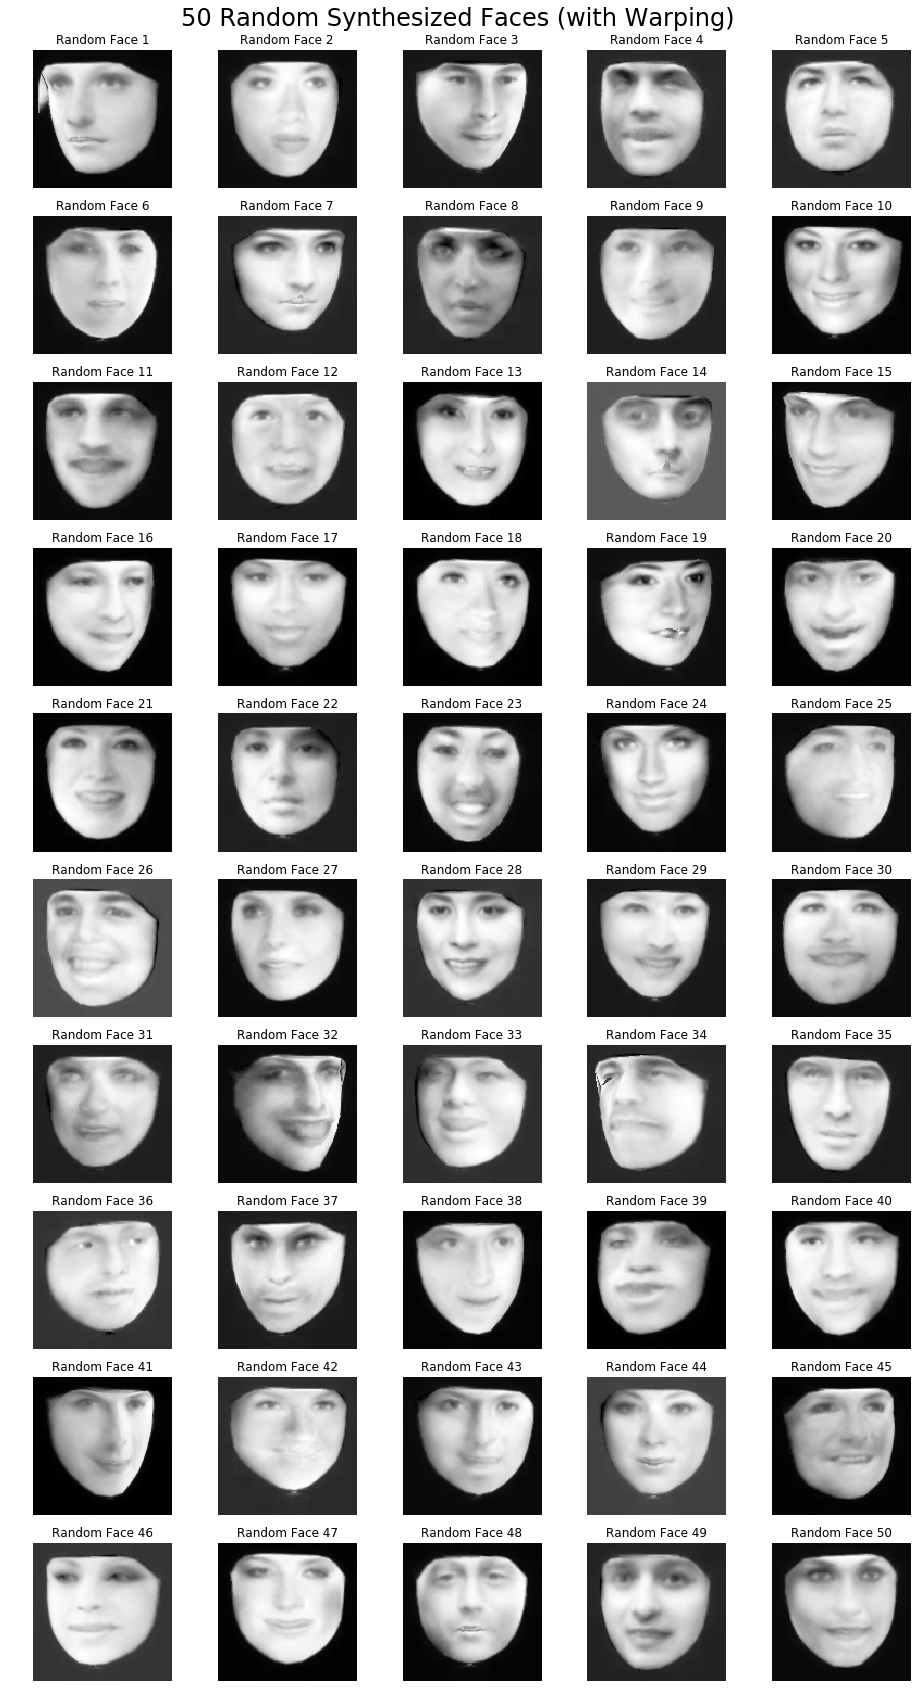

In [220]:
# ============ 2.1 Q4.1 get two bases ============= #
pca_face = PCA(n_components=50)
pca_face.fit(train_aligned_face_matrix_central.transpose())
aligned_eigen_faces = pca_face.components_.transpose()

pca_landmark = PCA(n_components=10)
pca_landmark.fit(train_landmark_matrix_central.transpose())
eigen_warpings = pca_landmark.components_.transpose()

# ============ 2.1 Q4.2 generate coefficient by normal distribution and plot 50 random faces ============= #
sqrt_eigen_faces = np.sqrt(pca_face.explained_variance_) # sqrt(eigen values)
sqrt_eigen_warpings = np.sqrt(pca_landmark.explained_variance_)

plt.figure(figsize=(16,30))
plt.suptitle('50 Random Synthesized Faces (with Warping)', fontsize=24, x=0.5, y=0.9)
for i in range(50):
    random_coef_face = np.random.randn(50) * sqrt_eigen_faces
    random_coef_landmark = np.random.randn(10) * sqrt_eigen_warpings

    random_recons_aligned_faces = np.dot(aligned_eigen_faces, random_coef_face) + mean_aligned_face_vector
    random_recons_aligned_faces = random_recons_aligned_faces.reshape((128, 128))

    random_recons_landmarks = np.dot(eigen_warpings, random_coef_landmark) + mean_landmark_vector
    random_recons_face = warp(random_recons_aligned_faces.reshape(128, 128, 1), mean_landmark, random_recons_landmarks.reshape((68, 2)))

    plt.subplot(10, 5, 1+i)
    plt.imshow(random_recons_face.reshape(128, 128), cmap='Greys_r')
    plt.title('Random Face ' + str(i+1), fontsize=12)
    plt.axis('off')
plt.show()